# the Transformer Architecture

most of the code here is a simplified version of [Karpathy's nanoGPT codebase](https://github.com/karpathy/nanoGPT/) -- check that out if you want to see a more practical implementation.

In [1]:
import math
from dataclasses import dataclass
from collections import Counter


from IPython.display import Image, display
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from jaxtyping import Int, Float
import matplotlib.pyplot as plt
import tqdm
import transformers

from utils.get_books import get_gutenberg_book, get_many_books
from utils.mermaid import mm
# from utils.analyze_vocab import analyze_vocab


In [2]:
# magic auto-reload for local development
%load_ext autoreload
%autoreload 2

to install required packages:
```
pip install -r requirements.txt
```

# Review


So:
- dense networks fail because they re-learn the same thing at every position
- convolutional networks give the *spatial* prior to our networks, great for images
- RNNs give the *temporal* prior to our networks, great for sequences -- but they decay over time

When we actually process language, we care about more than just *local* relationships of this sort:

![](https://upload.wikimedia.org/wikipedia/commons/8/8c/Parse2.jpg)

Many scientists tried for a very long time to try to encode parse trees in machines, but using human knowledge ended up being far less effective than letting the machines pick it up themselves.

The key insight of transformers and modern large language models is the *attention mechanism:*

> Given some sequence of inputs $[x_1, \ldots, x_n]$, when trying to predict the next token $x_{n+1}$, long range dependencies can be captured by letting a network choose which previous tokens to pay *attention* to.


> note on notation: we're now switching to $x_i$ being already embedded vectors in $\R^{d_m}$, rather than one-hot vectors in $\R^{d_V}$

The attention mechanism is a map $\mathbb{A} : \R^{d_m} \times (\R^{d_m})^{n_c} \to \R^{d_m}$ which takes a *query* $x_q$ and a *key* $x_k$ and produces a weighted sum of the values. We first consider the computation of scalar attention $A_s: \R^{d_m} \times \R^{d_m} \to \R$ for some head $s$.

$$ A_s(x_q, x_k) = \sigma \left( c \cdot x_q Q_s (x_k K_s)^T \right) $$

What are all these symbols? Firstly, we define $d_h$: the *head dimension*. We usually pick a number of heads `n_heads` and set $d_h = d_m / n_h$. Think of each head as a separate attention mechanism, kind of like different kernels in a convolutional layer.

- $c$ is a constant scalar, usually set to $\frac{1}{\sqrt{d_h}}$
- $Q_s, K_s \in \R^{d_m \times d_h}$ are learned linear maps - we have a different set of weights for each head
- $\sigma$ is the softmax function


Now, once we have the scalar attention $A_s$, we can define the full attention map $A: \R^{d_m} \times \R^{d_m} \to \R^{d_m}$ as follows:

$$ \mathbb{A}(x_q) = [ A_s(x_q, x_k) x_q V_s ]_{s \in \N_{n_h}} $$

$$ = \left[ \sigma \left( \frac{1}{\sqrt{d_h}} \cdot x_q Q_s (x_k K_s)^T \right) x_q V_s \right]_{s \in \N_{n_h}} $$

where $W^Q_i, W^K_i, W^V_i \in \R^{d_m \times d_h}$ are learned linear maps, and $V_i \in \R^{d_m}$ are learned vectors.



# Setting up configuration

- `d_model` $= d_m$
- `d_vocab` $= d_v$
- `n_context` $= n_c$
- `n_layer` $= n_L$
- `n_head` $= n_h$
- `d_head` $= d_h = \frac{d_m}{n_h}$

In [3]:
@dataclass(kw_only=True)
class GPTConfig:
    """defaults are the gpt-2 model"""
    d_model: int = 768
    d_vocab: int = 50257
    n_context: int = 1024
    n_layer: int = 12
    n_head: int = 12

    @property
    def d_head(self):
        assert self.d_model % self.n_head == 0, f"'{self.d_model = }' must be divisible by '{self.n_head = }': {self.d_model} % {self.n_head} == {self.d_model % self.n_head}"
        return self.d_model // self.n_head


# Attention Heads

I kind of lied to you earlier about the attention heads -- they don't actually operate over a pair of vectors, since the softmax gets applied over all items for that key.

Additionally, we implement *causal masking* by adding a matrix of $-\infty$.


Given some input $x \in \R^{n_c \times d_m}$, we can express our attention head $\mathbb{A}(x): \R^{n_c \times d_m} \to \R^{n_c \times d_h}$ as:


$$
	\mathbb{A}(x) := \left( \frac{\texttt{softmax}(x W_Q (x W_K)^T)}{\sqrt{d_h}} + M \right) x W_V
$$

Where $M$ is a causal mask, and

$$ 
	[M]_{i,j} = \begin{cases} 
		0 & i \geq j \\
		-\infty & i < j \\
	\end{cases}
$$




In [4]:
class AttentionHead(nn.Module):

    def __init__(self, config: GPTConfig):
        super().__init__()

        # store dimensions
        self.n_head: int = config.n_head
        self.d_model: int = config.d_model
        self.n_context: int = config.n_context

        # concatenating the outputs of the heads should give us d_model, but this check is done in GPTConfig
        self.d_head: int = config.d_head

        # coefficient for scaling the dot product of the query and key in the attention calculation
        self.sqrt_dim: float = 1.0 / math.sqrt(self.d_head)

        # key, query, value projections
        self.W_K: nn.Module = nn.Linear(self.d_model, self.d_head)
        self.W_Q: nn.Module = nn.Linear(self.d_model, self.d_head)
        self.W_V: nn.Module = nn.Linear(self.d_model, self.d_head)

        # causal mask to ensure that attention is only applied to the left in the input sequence
        # `register_buffer` means it's not a trainable parameter
        self.register_buffer(
            "causal_mask", 
            torch.tril(
                torch.ones(config.n_context, config.n_context)
            )
            .view(1, 1, config.n_context, config.n_context)
        )

    def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_head"]:
        assert x.ndim == 3, str(x.shape)
        B, n_ctx, d_model = x.shape # batch size, sequence length, embedding dimensionality (d_model)
        assert d_model == self.d_model, str(x.shape)
        # assert n_ctx == self.n_context, str(x.shape)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_Q(x)
        k: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_K(x)
        v: Float[torch.Tensor, "batch n_ctx d_head"] = self.W_V(x)

        # self-attention
        # (B, n_ctx, d_h) x (B, d_h, n_ctx) -> (B, n_ctx, n_ctx)
        att = (q @ k.transpose(-2, -1)) * self.sqrt_dim
        
        # autoregressive (causal) masking
        att = att.masked_fill(
            self.causal_mask[:,:n_ctx,:n_ctx] == 0, 
            float('-inf'),
        )

        # softmax
        att = F.softmax(att, dim=-1)

        # apply the self-attention to the values
        # (B, n_ctx, n_ctx) x (B, n_ctx, d_h) -> (B, n_ctx, d_h)
        output = att @ v
        return output.view(B, n_ctx, self.d_head)



now, you might notice that we also add another dimension `B` -- this is the *batch dimension*, and speeds things up a lot when we want to compute gradients over a set of samples. PyTorch broadcasts all operations over that batch dimension, so all the calculations are equivalent.

Let's check to see if the dimensions are correct:

In [5]:
cfg: GPTConfig = GPTConfig(
	n_context=128,
	d_model=64,
	n_head=4,
)
A: AttentionHead = AttentionHead(cfg)
print(A)

x = torch.randn(1, cfg.n_context, cfg.d_model)
print(f"{cfg.d_head = }")
print(f"{x.shape = }")
print(f"{A(x).shape = }")

AttentionHead(
  (W_K): Linear(in_features=64, out_features=16, bias=True)
  (W_Q): Linear(in_features=64, out_features=16, bias=True)
  (W_V): Linear(in_features=64, out_features=16, bias=True)
)
cfg.d_head = 16
x.shape = torch.Size([1, 128, 64])
A(x).shape = torch.Size([1, 128, 16])


does that look correct?


Now, let's take a look at that causal mask $M$, referred to as `causal_mask` in the code. You'll note that when we define it, it's actually a matrix of $\{0, 1\}$ and not $\{-\infty, 0\}$. However, in the `.forward()` function, we use `masked_fill` to set the elements of `attn` to $-\infty$ where $M$ is 0.

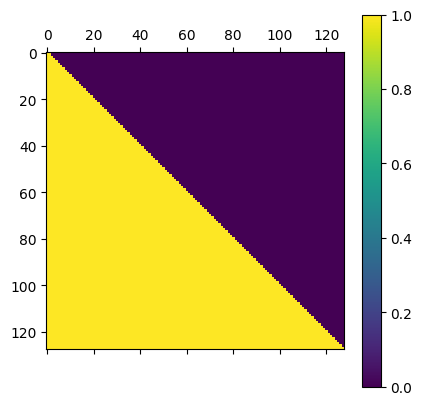

In [6]:
plt.matshow(A.causal_mask[0, 0].cpu().numpy())
plt.colorbar()
plt.show()

# Multi-headed attention

We can think of each attention head as learning some *concept* -- but we have many concepts we might need to learn, hence multiple attention heads. Let's call this function $\text{MHA}(x) : \R^{n_c \times d_m} \to \R^{n_c \times d_m}$. Given attention heads $[\mathbb{A}_1, \ldots, \mathbb{A}_{n_h}]$, we compute `MHA` as:


$$
	\texttt{MHA}(x) = \left[\begin{array}{c} 
		\mathbb{A}_1(x) \\ \hline
		\mathbb{A}_2(x) \\ \hline
		\vdots \\ \hline
		\mathbb{A}_{n_h}(x)
	\end{array}\right]
	\cdot [x W_O]
$$

Where $W_O \in \R^{d_m \times d_m}$ is just another learned linear map.


In our implementation, for readability and simplicity, we compute the attention heads one by one and then concatenate them. This is really really inefficient -- in reality you would do this all in one matrix multiplication, but the indexing for that gets complicated.

In [7]:
class MultiHeadedAttention(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()
		self.n_head: int = config.n_head
		self.d_head: int = config.d_model // config.n_head
		self.d_model: int = config.d_model

		# attention heads
		self.attention_heads: nn.ModuleList = nn.ModuleList([
			AttentionHead(config) 
			for _ in range(self.n_head)
		])

		# output projection
		self.W_O: nn.Module = nn.Linear(self.d_model, self.d_model)


	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		assert x.ndim == 3, str(x.shape)
		# apply all attention heads and concatenate their outputs
		# note: in reality, you would do this all in one tensor
		# we split the attention heads up to make it easier to understand
		att = torch.cat(
			[
				head(x) 
				for head in self.attention_heads
			],
			dim=-1,
		)
		assert len(att.shape) == 3, str(att.shape)

		# output projection
		# (B, n_ctx, d_head * n_head) -> (B, n_ctx, d_model)
		output = self.W_O(att)
		assert output.shape == x.shape, str(output.shape)
		return output


# Transformers

![Figure 1: a Transformer](assets/transformers_robot.png)

A transformer is made up of *Transformer Blocks*

In [8]:

mm("""
graph TD;
subgraph TransformerBlock
    x((x))
    x --> ln_1
	ln_1 --> MHA
    z((z))
	MHA --> z
    x --> z
    z --> ln_2
	ln_2 --> MLP
	y((y))
   	MLP --> y
    z --> y
end
""")

In [9]:
class TransformerBlock(nn.Module):
	def __init__(self, config: GPTConfig):
		super().__init__()

		# layernorm, attention, another layernorm, mlp
		self.ln_1: nn.Module = nn.LayerNorm(config.d_model)
		self.attention: nn.Module = MultiHeadedAttention(config)
		self.ln_2: nn.Module = nn.LayerNorm(config.d_model)
		self.mlp: nn.Module = nn.Sequential(
			nn.Linear(config.d_model, 4 * config.d_model),
			nn.GELU(),
			nn.Linear(4 * config.d_model, config.d_model),
		)

	def forward(self, x: Float[torch.Tensor, "batch n_ctx d_model"]) -> Float[torch.Tensor, "batch n_ctx d_model"]:
		z = x + self.attention(self.ln_1(x))
		return z + self.mlp(self.ln_2(z))

What's this `LayerNorm` thing?

see: https://arxiv.org/abs/1607.06450

$$ \texttt{LayerNorm}(x) = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta $$

Now, finally, for the GPT itself!

In [10]:
mm("""
graph TD;
subgraph GPT
    prompt((prompt))
    wte[\Token Embedding/]
	wpe{{Positional Encoding}}
    TB1[[TransformerBlock_1]]
    TB2[[TransformerBlock_2]]
	TB_dots{...}
    TBnL[[TransformerBlock_n_L]]
    ln_f[[LayerNorm]]
    lm_head[/De-Embedding\]
   
    prompt --> wte
    prompt --> wpe
    wte --> TB1
    wpe --> TB1
    TB1 --> TB2
    TB2 --> TB_dots
    TB_dots --> TBnL
    TBnL --> ln_f
    ln_f --> lm_head
end
""")

In [19]:
class GPT(nn.Module):
	def __init__(self, config: GPTConfig, tokenizer: transformers.PreTrainedTokenizer):
		super().__init__()

		self.config: GPTConfig = config
		self.tokenizer: transformers.PreTrainedTokenizer = tokenizer
		assert config.d_vocab >= tokenizer.vocab_size

		# token and positional embeddings
		self.token_embeddings: nn.Module = nn.Embedding(config.d_vocab, config.d_model)
		self.positional_embeddings: nn.Module = nn.Embedding(config.n_context, config.d_model)

		# transformer
		self.transformer_blocks: nn.ModuleList = nn.ModuleList([
			TransformerBlock(config) 
			for _ in range(config.n_layer)
		])

		# language model head
		self.ln_f: nn.Module = nn.LayerNorm(config.d_model)
		self.lm_head: nn.Module = nn.Linear(config.d_model, config.d_vocab, bias=False)

	def forward(
			self, 
			x: Int[torch.Tensor, "batch n_ctx"],
			targets: Int[torch.Tensor, "batch n_ctx"]|None = None,
		) -> tuple:
		"""returns a tuple of (logits, loss) where loss=None if targets is None"""
		assert x.ndim == 2, str(x.shape)

		# calculate token and positional embeddings and sum them
		x_res = (
			self.token_embeddings(x) 
			+ self.positional_embeddings(torch.arange(x.size(1), device=x.device))
		)

		assert x_res.ndim == 3, str(x.shape)

		# transformer blocks
		for i, block in enumerate(self.transformer_blocks):
			x_res = block(x_res)

		# language model head
		logits: Float[torch.Tensor, "batch n_ctx d_vocab"] = self.lm_head(self.ln_f(x_res))

		loss = None
		if targets is not None:
			loss = F.cross_entropy(
				logits.transpose(1, 2),
				targets,
				ignore_index=-1,
			)

		return logits, loss
	
	@torch.no_grad()
	def generate(
		self,
		prompt: str|list[int]|Int[torch.Tensor, "* n_ctx"],
		max_new_tokens: int = 128,
		temperature: float = 1.0,
	) -> str:

		# convert prompt to string and tensor versions
		prompt_str: str
		prompt_tensor: Int[torch.Tensor, "1 n_ctx"]
		if isinstance(prompt, str):
			prompt_str = prompt
			prompt_tensor = torch.tensor(self.tokenizer.encode(prompt_str), dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, list):
			prompt_str = self.tokenizer.decode(prompt)
			prompt_tensor = torch.tensor(prompt, dtype=torch.long).unsqueeze(0) # add batch dim
		elif isinstance(prompt, torch.Tensor):
			if prompt.ndim == 1:
				prompt = prompt.unsqueeze(0) # add batch dim
			assert prompt.ndim == 2

			prompt_str = self.tokenizer.decode(prompt[0].tolist())
			prompt_tensor = prompt
		else:
			raise ValueError(f"prompt must be a string, list of ints, or PyTorch tensor")
		
		# check tensor dims
		assert isinstance(prompt_str, str) 
		assert isinstance(prompt_tensor, torch.Tensor)
		assert prompt_tensor.ndim == 2 
		assert prompt_tensor.shape[0] == 1

		#  device
		prompt_tensor = prompt_tensor.to(self.device)

		# pad the prompt if necessary
		if prompt_tensor.shape[1] < self.config.n_context:
			prompt_tensor = F.pad(prompt_tensor, (0, self.config.n_context - prompt_tensor.shape[1]), value=self.tokenizer.pad_token_id)

		assert prompt_tensor.shape[1] == self.config.n_context

		# iterate until max_new_tokens is reached, or an end-of-sequence token is generated
		completions: list[int] = list()
		for _ in range(max_new_tokens):
			# truncate sequence to block size
			prompt_len: int = prompt_tensor.shape[1]
			if prompt_len > self.config.n_context:
				prompt_tensor = prompt_tensor[:, -self.config.n_context:]

			# forward the model to get the logits for the index in the sequence
			logits, _ = self(prompt_tensor)

			# pluck the logits at the final step and scale by desired temperature
			logits = logits[:, -1, :] / temperature

			# apply softmax to convert logits to (normalized) probabilities
			probs = F.softmax(logits, dim=-1)

			# sample from the distribution
			idx_next = torch.multinomial(probs, num_samples=1)

			# append sampled index to the running sequence and continue
			idx = torch.cat((prompt_tensor, idx_next), dim=1)

			# append the token to the running completions
			completions.append(int(idx_next[0, 0]))

			# check if end of sequence token is generated
			if idx_next == self.tokenizer.eos_token_id:
				break

		return self.tokenizer.decode(completions)

	@property
	def n_params(self) -> int:
		return sum(p.numel() for p in self.parameters())
	
	@property
	def device(self) -> torch.device:
		device_set: set[torch.device] = set(p.device for p in self.parameters())
		assert len(device_set) == 1, device_set
		return next(iter(device_set))

# Dataset

In [12]:
text_data: str = ' '.join(get_many_books([84, 15, 18, 82, 996, 2600]))

Getting book 84...
	426812 characters read
Getting book 15...
	1241057 characters read
Getting book 18...
	1191616 characters read
Getting book 82...
	1125004 characters read
Getting book 996...
	2342280 characters read
Getting book 2600...
	3274016 characters read


In [13]:
class TextDataset(Dataset):
	def __init__(
			self, 
			text: str, 
			tokenizer: transformers.PreTrainedTokenizer,
			n_context: int,
			ensure_n_context_match: bool = True,
		):
		# tokenize the text
		tokenized_text: list[int] = tokenizer.encode(text)
		self.total_tokens: int = len(tokenized_text)

		# trim the last tokens to make sure the length is a multiple of n_context
		if ensure_n_context_match:
			tokenized_text = tokenized_text[:-(len(tokenized_text) % n_context)]
			self.total_tokens = len(tokenized_text)

		# split the text into examples of length n_context
		# this means that text will often start in the middle of a sentence
		# in reality, we might want to do this a bit smarter
		self.examples: list[list[int]] = [
			tokenized_text[i:i+n_context] 
			for i in range(0, len(tokenized_text), n_context)
		]

	def __len__(self) -> int:
		return len(self.examples)
	
	def __getitem__(self, i: int) -> Float[torch.Tensor, "n_ctx"]:
		return torch.tensor(self.examples[i], dtype=torch.long)
	
	def example_lengths(self) -> Counter[int]:
		return Counter(len(ex) for ex in self.examples)

# Training Loop

In [14]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:-1, :],
				targets=batch[1:, :], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

	return model, training_records



# running it all

In [28]:
# we want to ensure our vocab dimension is the same as the tokenizer's vocab size
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = }")

print(f"{TOKENIZER.eos_token = }, {TOKENIZER.eos_token_id = }")

# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=4096,
	d_vocab=TOKENIZER.vocab_size,
	n_context=1024,
	n_layer=128,
	n_head=128,
)

# initialize the model
MODEL: GPT = GPT(CONFIG, TOKENIZER)
print(f"{MODEL.n_params = }")

# optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-4)


TOKENIZER.vocab_size = 50257
TOKENIZER.eos_token = '<|endoftext|>', TOKENIZER.eos_token_id = 50256


KeyboardInterrupt: 

In [16]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=32,
	max_batches=None,
	print_interval=100,
	epochs=5,
)

moving model to device: cuda
setting up dataset from text of length 1000000


Token indices sequence length is longer than the specified maximum sequence length for this model (268054 > 1024). Running this sequence through the model will result in indexing errors


	set up dataset with 2094 examples, example lengths: Counter({128: 2094})
setting up dataloader from 2094 examples
	set up dataloader with 66 batches of size 32
training...
Epoch 1/5



Training:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([31, 128])


Training:   2%|▏         | 1/66 [00:02<02:46,  2.56s/it]

Batch 0, Loss: 11.005831718444824

torch.Size([31, 128])


Training:   3%|▎         | 2/66 [00:02<01:19,  1.24s/it]

torch.Size([31, 128])


Training:   5%|▍         | 3/66 [00:03<00:51,  1.23it/s]

torch.Size([31, 128])


Training:   6%|▌         | 4/66 [00:03<00:37,  1.65it/s]

torch.Size([31, 128])


Training:   8%|▊         | 5/66 [00:03<00:30,  2.02it/s]

torch.Size([31, 128])


Training:   9%|▉         | 6/66 [00:04<00:25,  2.34it/s]

torch.Size([31, 128])


Training:  11%|█         | 7/66 [00:04<00:22,  2.59it/s]

torch.Size([31, 128])


Training:  12%|█▏        | 8/66 [00:04<00:21,  2.76it/s]

torch.Size([31, 128])


Training:  14%|█▎        | 9/66 [00:04<00:19,  2.88it/s]

torch.Size([31, 128])


Training:  15%|█▌        | 10/66 [00:05<00:18,  2.97it/s]

torch.Size([31, 128])


Training:  17%|█▋        | 11/66 [00:05<00:17,  3.06it/s]

torch.Size([31, 128])


Training:  18%|█▊        | 12/66 [00:05<00:17,  3.11it/s]

torch.Size([31, 128])


Training:  20%|█▉        | 13/66 [00:06<00:16,  3.14it/s]

torch.Size([31, 128])


Training:  21%|██        | 14/66 [00:06<00:16,  3.17it/s]

torch.Size([31, 128])


Training:  23%|██▎       | 15/66 [00:06<00:15,  3.20it/s]

torch.Size([31, 128])


Training:  24%|██▍       | 16/66 [00:07<00:15,  3.21it/s]

torch.Size([31, 128])


Training:  26%|██▌       | 17/66 [00:07<00:15,  3.25it/s]

torch.Size([31, 128])


Training:  27%|██▋       | 18/66 [00:07<00:14,  3.25it/s]

torch.Size([31, 128])


Training:  29%|██▉       | 19/66 [00:08<00:14,  3.22it/s]

torch.Size([31, 128])


Training:  30%|███       | 20/66 [00:08<00:14,  3.25it/s]

torch.Size([31, 128])


Training:  32%|███▏      | 21/66 [00:08<00:13,  3.27it/s]

torch.Size([31, 128])


Training:  33%|███▎      | 22/66 [00:08<00:13,  3.23it/s]

torch.Size([31, 128])


Training:  35%|███▍      | 23/66 [00:09<00:13,  3.27it/s]

torch.Size([31, 128])


Training:  36%|███▋      | 24/66 [00:09<00:12,  3.29it/s]

torch.Size([31, 128])


Training:  38%|███▊      | 25/66 [00:09<00:12,  3.25it/s]

torch.Size([31, 128])


Training:  39%|███▉      | 26/66 [00:10<00:12,  3.27it/s]

torch.Size([31, 128])


Training:  41%|████      | 27/66 [00:10<00:12,  3.23it/s]

torch.Size([31, 128])


Training:  42%|████▏     | 28/66 [00:10<00:11,  3.24it/s]

torch.Size([31, 128])


Training:  44%|████▍     | 29/66 [00:11<00:11,  3.24it/s]

torch.Size([31, 128])


Training:  45%|████▌     | 30/66 [00:11<00:11,  3.23it/s]

torch.Size([31, 128])


Training:  47%|████▋     | 31/66 [00:11<00:10,  3.22it/s]

torch.Size([31, 128])


Training:  48%|████▊     | 32/66 [00:12<00:10,  3.24it/s]

torch.Size([31, 128])


Training:  50%|█████     | 33/66 [00:12<00:10,  3.23it/s]

torch.Size([31, 128])


Training:  52%|█████▏    | 34/66 [00:12<00:09,  3.28it/s]

torch.Size([31, 128])


Training:  53%|█████▎    | 35/66 [00:12<00:09,  3.26it/s]

torch.Size([31, 128])


Training:  55%|█████▍    | 36/66 [00:13<00:09,  3.27it/s]

torch.Size([31, 128])


Training:  56%|█████▌    | 37/66 [00:13<00:08,  3.22it/s]

torch.Size([31, 128])


Training:  58%|█████▊    | 38/66 [00:13<00:08,  3.23it/s]

torch.Size([31, 128])


Training:  59%|█████▉    | 39/66 [00:14<00:08,  3.22it/s]

torch.Size([31, 128])


Training:  61%|██████    | 40/66 [00:14<00:07,  3.29it/s]

torch.Size([31, 128])


Training:  62%|██████▏   | 41/66 [00:14<00:07,  3.24it/s]

torch.Size([31, 128])


Training:  64%|██████▎   | 42/66 [00:15<00:07,  3.25it/s]

torch.Size([31, 128])


Training:  65%|██████▌   | 43/66 [00:15<00:07,  3.23it/s]

torch.Size([31, 128])


Training:  67%|██████▋   | 44/66 [00:15<00:06,  3.24it/s]

torch.Size([31, 128])


Training:  68%|██████▊   | 45/66 [00:16<00:06,  3.21it/s]

torch.Size([31, 128])


Training:  70%|██████▉   | 46/66 [00:16<00:06,  3.23it/s]

torch.Size([31, 128])


Training:  71%|███████   | 47/66 [00:16<00:05,  3.28it/s]

torch.Size([31, 128])


Training:  73%|███████▎  | 48/66 [00:16<00:05,  3.27it/s]

torch.Size([31, 128])


Training:  74%|███████▍  | 49/66 [00:17<00:05,  3.29it/s]

torch.Size([31, 128])


Training:  76%|███████▌  | 50/66 [00:17<00:04,  3.26it/s]

torch.Size([31, 128])


Training:  77%|███████▋  | 51/66 [00:17<00:04,  3.25it/s]

torch.Size([31, 128])


Training:  79%|███████▉  | 52/66 [00:18<00:04,  3.28it/s]

torch.Size([31, 128])


Training:  80%|████████  | 53/66 [00:18<00:03,  3.27it/s]

torch.Size([31, 128])


Training:  82%|████████▏ | 54/66 [00:18<00:03,  3.26it/s]

torch.Size([31, 128])


Training:  83%|████████▎ | 55/66 [00:19<00:03,  3.23it/s]

torch.Size([31, 128])


Training:  85%|████████▍ | 56/66 [00:19<00:03,  3.23it/s]

torch.Size([31, 128])


Training:  86%|████████▋ | 57/66 [00:19<00:02,  3.23it/s]

torch.Size([31, 128])


Training:  88%|████████▊ | 58/66 [00:20<00:02,  3.24it/s]

torch.Size([31, 128])


Training:  89%|████████▉ | 59/66 [00:20<00:02,  3.25it/s]

torch.Size([31, 128])


Training:  91%|█████████ | 60/66 [00:20<00:01,  3.24it/s]

torch.Size([31, 128])


Training:  92%|█████████▏| 61/66 [00:21<00:01,  3.23it/s]

torch.Size([31, 128])


Training:  94%|█████████▍| 62/66 [00:21<00:01,  3.24it/s]

torch.Size([31, 128])


Training:  95%|█████████▌| 63/66 [00:21<00:00,  3.20it/s]

torch.Size([31, 128])


Training:  97%|█████████▋| 64/66 [00:21<00:00,  3.24it/s]

torch.Size([31, 128])


Training: 100%|██████████| 66/66 [00:22<00:00,  3.64it/s]

torch.Size([13, 128])


Training: 100%|██████████| 66/66 [00:22<00:00,  2.94it/s]


Epoch 2/5



Training:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([31, 128])


Training:   2%|▏         | 1/66 [00:00<00:19,  3.38it/s]

Batch 0, Loss: 10.422276496887207

torch.Size([31, 128])


Training:   3%|▎         | 2/66 [00:00<00:19,  3.30it/s]

torch.Size([31, 128])


Training:   5%|▍         | 3/66 [00:00<00:18,  3.32it/s]

torch.Size([31, 128])


Training:   6%|▌         | 4/66 [00:01<00:19,  3.26it/s]

torch.Size([31, 128])


Training:   8%|▊         | 5/66 [00:01<00:18,  3.33it/s]

torch.Size([31, 128])


Training:   9%|▉         | 6/66 [00:01<00:17,  3.35it/s]

torch.Size([31, 128])


Training:  11%|█         | 7/66 [00:02<00:17,  3.32it/s]

torch.Size([31, 128])


Training:  12%|█▏        | 8/66 [00:02<00:17,  3.32it/s]

torch.Size([31, 128])


Training:  14%|█▎        | 9/66 [00:02<00:17,  3.29it/s]

torch.Size([31, 128])


Training:  15%|█▌        | 10/66 [00:03<00:17,  3.29it/s]

torch.Size([31, 128])


Training:  17%|█▋        | 11/66 [00:03<00:16,  3.32it/s]

torch.Size([31, 128])


Training:  18%|█▊        | 12/66 [00:03<00:16,  3.25it/s]

torch.Size([31, 128])


Training:  20%|█▉        | 13/66 [00:03<00:16,  3.24it/s]

torch.Size([31, 128])


Training:  21%|██        | 14/66 [00:04<00:16,  3.24it/s]

torch.Size([31, 128])


Training:  23%|██▎       | 15/66 [00:04<00:15,  3.20it/s]

torch.Size([31, 128])


Training:  24%|██▍       | 16/66 [00:04<00:15,  3.21it/s]

torch.Size([31, 128])


Training:  26%|██▌       | 17/66 [00:05<00:15,  3.24it/s]

torch.Size([31, 128])


Training:  27%|██▋       | 18/66 [00:05<00:14,  3.24it/s]

torch.Size([31, 128])


Training:  29%|██▉       | 19/66 [00:05<00:14,  3.23it/s]

torch.Size([31, 128])


Training:  30%|███       | 20/66 [00:06<00:14,  3.21it/s]

torch.Size([31, 128])


Training:  32%|███▏      | 21/66 [00:06<00:13,  3.24it/s]

torch.Size([31, 128])


Training:  33%|███▎      | 22/66 [00:06<00:13,  3.29it/s]

torch.Size([31, 128])


Training:  35%|███▍      | 23/66 [00:07<00:13,  3.29it/s]

torch.Size([31, 128])


Training:  36%|███▋      | 24/66 [00:07<00:12,  3.31it/s]

torch.Size([31, 128])


Training:  38%|███▊      | 25/66 [00:07<00:12,  3.28it/s]

torch.Size([31, 128])


Training:  39%|███▉      | 26/66 [00:07<00:12,  3.30it/s]

torch.Size([31, 128])


Training:  41%|████      | 27/66 [00:08<00:11,  3.33it/s]

torch.Size([31, 128])


Training:  42%|████▏     | 28/66 [00:08<00:11,  3.28it/s]

torch.Size([31, 128])


Training:  44%|████▍     | 29/66 [00:08<00:11,  3.30it/s]

torch.Size([31, 128])


Training:  45%|████▌     | 30/66 [00:09<00:10,  3.34it/s]

torch.Size([31, 128])


Training:  47%|████▋     | 31/66 [00:09<00:10,  3.31it/s]

torch.Size([31, 128])


Training:  48%|████▊     | 32/66 [00:09<00:10,  3.37it/s]

torch.Size([31, 128])


Training:  50%|█████     | 33/66 [00:10<00:09,  3.36it/s]

torch.Size([31, 128])


Training:  52%|█████▏    | 34/66 [00:10<00:09,  3.29it/s]

torch.Size([31, 128])


Training:  53%|█████▎    | 35/66 [00:10<00:09,  3.25it/s]

torch.Size([31, 128])


Training:  55%|█████▍    | 36/66 [00:10<00:09,  3.27it/s]

torch.Size([31, 128])


Training:  56%|█████▌    | 37/66 [00:11<00:08,  3.24it/s]

torch.Size([31, 128])


Training:  58%|█████▊    | 38/66 [00:11<00:08,  3.23it/s]

torch.Size([31, 128])


Training:  59%|█████▉    | 39/66 [00:11<00:08,  3.25it/s]

torch.Size([31, 128])


Training:  61%|██████    | 40/66 [00:12<00:07,  3.27it/s]

torch.Size([31, 128])


Training:  62%|██████▏   | 41/66 [00:12<00:07,  3.24it/s]

torch.Size([31, 128])


Training:  64%|██████▎   | 42/66 [00:12<00:07,  3.22it/s]

torch.Size([31, 128])


Training:  65%|██████▌   | 43/66 [00:13<00:07,  3.25it/s]

torch.Size([31, 128])


Training:  67%|██████▋   | 44/66 [00:13<00:06,  3.26it/s]

torch.Size([31, 128])


Training:  68%|██████▊   | 45/66 [00:13<00:06,  3.26it/s]

torch.Size([31, 128])


Training:  70%|██████▉   | 46/66 [00:14<00:06,  3.24it/s]

torch.Size([31, 128])


Training:  71%|███████   | 47/66 [00:14<00:05,  3.23it/s]

torch.Size([31, 128])


Training:  73%|███████▎  | 48/66 [00:14<00:05,  3.22it/s]

torch.Size([31, 128])


Training:  74%|███████▍  | 49/66 [00:14<00:05,  3.24it/s]

torch.Size([31, 128])


Training:  76%|███████▌  | 50/66 [00:15<00:05,  3.20it/s]

torch.Size([31, 128])


Training:  77%|███████▋  | 51/66 [00:15<00:04,  3.22it/s]

torch.Size([31, 128])


Training:  79%|███████▉  | 52/66 [00:15<00:04,  3.21it/s]

torch.Size([31, 128])


Training:  80%|████████  | 53/66 [00:16<00:04,  3.20it/s]

torch.Size([31, 128])


Training:  82%|████████▏ | 54/66 [00:16<00:03,  3.19it/s]

torch.Size([31, 128])


Training:  83%|████████▎ | 55/66 [00:16<00:03,  3.24it/s]

torch.Size([31, 128])


Training:  85%|████████▍ | 56/66 [00:17<00:03,  3.24it/s]

torch.Size([31, 128])


Training:  86%|████████▋ | 57/66 [00:17<00:02,  3.24it/s]

torch.Size([31, 128])


Training:  88%|████████▊ | 58/66 [00:17<00:02,  3.29it/s]

torch.Size([31, 128])


Training:  89%|████████▉ | 59/66 [00:18<00:02,  3.25it/s]

torch.Size([31, 128])


Training:  91%|█████████ | 60/66 [00:18<00:01,  3.22it/s]

torch.Size([31, 128])


Training:  92%|█████████▏| 61/66 [00:18<00:01,  3.25it/s]

torch.Size([31, 128])


Training:  94%|█████████▍| 62/66 [00:19<00:01,  3.20it/s]

torch.Size([31, 128])


Training:  95%|█████████▌| 63/66 [00:19<00:00,  3.22it/s]

torch.Size([31, 128])


Training:  97%|█████████▋| 64/66 [00:19<00:00,  3.22it/s]

torch.Size([31, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.61it/s]

torch.Size([13, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.28it/s]


Epoch 3/5



Training:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([31, 128])


Training:   2%|▏         | 1/66 [00:00<00:19,  3.39it/s]

Batch 0, Loss: 9.268083572387695

torch.Size([31, 128])


Training:   3%|▎         | 2/66 [00:00<00:19,  3.29it/s]

torch.Size([31, 128])


Training:   5%|▍         | 3/66 [00:00<00:19,  3.23it/s]

torch.Size([31, 128])


Training:   6%|▌         | 4/66 [00:01<00:19,  3.23it/s]

torch.Size([31, 128])


Training:   8%|▊         | 5/66 [00:01<00:19,  3.20it/s]

torch.Size([31, 128])


Training:   9%|▉         | 6/66 [00:01<00:18,  3.22it/s]

torch.Size([31, 128])


Training:  11%|█         | 7/66 [00:02<00:18,  3.25it/s]

torch.Size([31, 128])


Training:  12%|█▏        | 8/66 [00:02<00:17,  3.27it/s]

torch.Size([31, 128])


Training:  14%|█▎        | 9/66 [00:02<00:17,  3.27it/s]

torch.Size([31, 128])


Training:  15%|█▌        | 10/66 [00:03<00:17,  3.23it/s]

torch.Size([31, 128])


Training:  17%|█▋        | 11/66 [00:03<00:17,  3.23it/s]

torch.Size([31, 128])


Training:  18%|█▊        | 12/66 [00:03<00:16,  3.25it/s]

torch.Size([31, 128])


Training:  20%|█▉        | 13/66 [00:04<00:16,  3.26it/s]

torch.Size([31, 128])


Training:  21%|██        | 14/66 [00:04<00:15,  3.25it/s]

torch.Size([31, 128])


Training:  23%|██▎       | 15/66 [00:04<00:15,  3.28it/s]

torch.Size([31, 128])


Training:  24%|██▍       | 16/66 [00:04<00:15,  3.30it/s]

torch.Size([31, 128])


Training:  26%|██▌       | 17/66 [00:05<00:15,  3.26it/s]

torch.Size([31, 128])


Training:  27%|██▋       | 18/66 [00:05<00:14,  3.29it/s]

torch.Size([31, 128])


Training:  29%|██▉       | 19/66 [00:05<00:14,  3.29it/s]

torch.Size([31, 128])


Training:  30%|███       | 20/66 [00:06<00:14,  3.25it/s]

torch.Size([31, 128])


Training:  32%|███▏      | 21/66 [00:06<00:13,  3.25it/s]

torch.Size([31, 128])


Training:  33%|███▎      | 22/66 [00:06<00:13,  3.28it/s]

torch.Size([31, 128])


Training:  35%|███▍      | 23/66 [00:07<00:13,  3.29it/s]

torch.Size([31, 128])


Training:  36%|███▋      | 24/66 [00:07<00:12,  3.27it/s]

torch.Size([31, 128])


Training:  38%|███▊      | 25/66 [00:07<00:12,  3.27it/s]

torch.Size([31, 128])


Training:  39%|███▉      | 26/66 [00:07<00:12,  3.25it/s]

torch.Size([31, 128])


Training:  41%|████      | 27/66 [00:08<00:12,  3.24it/s]

torch.Size([31, 128])


Training:  42%|████▏     | 28/66 [00:08<00:11,  3.26it/s]

torch.Size([31, 128])


Training:  44%|████▍     | 29/66 [00:08<00:11,  3.26it/s]

torch.Size([31, 128])


Training:  45%|████▌     | 30/66 [00:09<00:11,  3.25it/s]

torch.Size([31, 128])


Training:  47%|████▋     | 31/66 [00:09<00:10,  3.27it/s]

torch.Size([31, 128])


Training:  48%|████▊     | 32/66 [00:09<00:10,  3.25it/s]

torch.Size([31, 128])


Training:  50%|█████     | 33/66 [00:10<00:10,  3.23it/s]

torch.Size([31, 128])


Training:  52%|█████▏    | 34/66 [00:10<00:09,  3.24it/s]

torch.Size([31, 128])


Training:  53%|█████▎    | 35/66 [00:10<00:09,  3.27it/s]

torch.Size([31, 128])


Training:  55%|█████▍    | 36/66 [00:11<00:09,  3.27it/s]

torch.Size([31, 128])


Training:  56%|█████▌    | 37/66 [00:11<00:08,  3.24it/s]

torch.Size([31, 128])


Training:  58%|█████▊    | 38/66 [00:11<00:08,  3.23it/s]

torch.Size([31, 128])


Training:  59%|█████▉    | 39/66 [00:11<00:08,  3.26it/s]

torch.Size([31, 128])


Training:  61%|██████    | 40/66 [00:12<00:08,  3.21it/s]

torch.Size([31, 128])


Training:  62%|██████▏   | 41/66 [00:12<00:07,  3.22it/s]

torch.Size([31, 128])


Training:  64%|██████▎   | 42/66 [00:12<00:07,  3.23it/s]

torch.Size([31, 128])


Training:  65%|██████▌   | 43/66 [00:13<00:07,  3.23it/s]

torch.Size([31, 128])


Training:  67%|██████▋   | 44/66 [00:13<00:06,  3.25it/s]

torch.Size([31, 128])


Training:  68%|██████▊   | 45/66 [00:13<00:06,  3.23it/s]

torch.Size([31, 128])


Training:  70%|██████▉   | 46/66 [00:14<00:06,  3.26it/s]

torch.Size([31, 128])


Training:  71%|███████   | 47/66 [00:14<00:05,  3.27it/s]

torch.Size([31, 128])


Training:  73%|███████▎  | 48/66 [00:14<00:05,  3.30it/s]

torch.Size([31, 128])


Training:  74%|███████▍  | 49/66 [00:15<00:05,  3.25it/s]

torch.Size([31, 128])


Training:  76%|███████▌  | 50/66 [00:15<00:04,  3.24it/s]

torch.Size([31, 128])


Training:  77%|███████▋  | 51/66 [00:15<00:04,  3.23it/s]

torch.Size([31, 128])


Training:  79%|███████▉  | 52/66 [00:15<00:04,  3.22it/s]

torch.Size([31, 128])


Training:  80%|████████  | 53/66 [00:16<00:03,  3.26it/s]

torch.Size([31, 128])


Training:  82%|████████▏ | 54/66 [00:16<00:03,  3.28it/s]

torch.Size([31, 128])


Training:  83%|████████▎ | 55/66 [00:16<00:03,  3.27it/s]

torch.Size([31, 128])


Training:  85%|████████▍ | 56/66 [00:17<00:03,  3.25it/s]

torch.Size([31, 128])


Training:  86%|████████▋ | 57/66 [00:17<00:02,  3.22it/s]

torch.Size([31, 128])


Training:  88%|████████▊ | 58/66 [00:17<00:02,  3.23it/s]

torch.Size([31, 128])


Training:  89%|████████▉ | 59/66 [00:18<00:02,  3.25it/s]

torch.Size([31, 128])


Training:  91%|█████████ | 60/66 [00:18<00:01,  3.28it/s]

torch.Size([31, 128])


Training:  92%|█████████▏| 61/66 [00:18<00:01,  3.25it/s]

torch.Size([31, 128])


Training:  94%|█████████▍| 62/66 [00:19<00:01,  3.22it/s]

torch.Size([31, 128])


Training:  95%|█████████▌| 63/66 [00:19<00:00,  3.27it/s]

torch.Size([31, 128])


Training:  97%|█████████▋| 64/66 [00:19<00:00,  3.27it/s]

torch.Size([31, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.72it/s]

torch.Size([13, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s]


Epoch 4/5



Training:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([31, 128])


Training:   2%|▏         | 1/66 [00:00<00:19,  3.31it/s]

Batch 0, Loss: 8.56855583190918

torch.Size([31, 128])


Training:   3%|▎         | 2/66 [00:00<00:19,  3.34it/s]

torch.Size([31, 128])


Training:   5%|▍         | 3/66 [00:00<00:19,  3.22it/s]

torch.Size([31, 128])


Training:   6%|▌         | 4/66 [00:01<00:19,  3.24it/s]

torch.Size([31, 128])


Training:   8%|▊         | 5/66 [00:01<00:18,  3.22it/s]

torch.Size([31, 128])


Training:   9%|▉         | 6/66 [00:01<00:18,  3.29it/s]

torch.Size([31, 128])


Training:  11%|█         | 7/66 [00:02<00:17,  3.28it/s]

torch.Size([31, 128])


Training:  12%|█▏        | 8/66 [00:02<00:17,  3.27it/s]

torch.Size([31, 128])


Training:  14%|█▎        | 9/66 [00:02<00:17,  3.27it/s]

torch.Size([31, 128])


Training:  15%|█▌        | 10/66 [00:03<00:17,  3.25it/s]

torch.Size([31, 128])


Training:  17%|█▋        | 11/66 [00:03<00:17,  3.23it/s]

torch.Size([31, 128])


Training:  18%|█▊        | 12/66 [00:03<00:16,  3.26it/s]

torch.Size([31, 128])


Training:  20%|█▉        | 13/66 [00:03<00:16,  3.28it/s]

torch.Size([31, 128])


Training:  21%|██        | 14/66 [00:04<00:15,  3.29it/s]

torch.Size([31, 128])


Training:  23%|██▎       | 15/66 [00:04<00:15,  3.26it/s]

torch.Size([31, 128])


Training:  24%|██▍       | 16/66 [00:04<00:15,  3.24it/s]

torch.Size([31, 128])


Training:  26%|██▌       | 17/66 [00:05<00:15,  3.26it/s]

torch.Size([31, 128])


Training:  27%|██▋       | 18/66 [00:05<00:14,  3.28it/s]

torch.Size([31, 128])


Training:  29%|██▉       | 19/66 [00:05<00:14,  3.29it/s]

torch.Size([31, 128])


Training:  30%|███       | 20/66 [00:06<00:14,  3.28it/s]

torch.Size([31, 128])


Training:  32%|███▏      | 21/66 [00:06<00:13,  3.24it/s]

torch.Size([31, 128])


Training:  33%|███▎      | 22/66 [00:06<00:13,  3.26it/s]

torch.Size([31, 128])


Training:  35%|███▍      | 23/66 [00:07<00:13,  3.27it/s]

torch.Size([31, 128])


Training:  36%|███▋      | 24/66 [00:07<00:12,  3.27it/s]

torch.Size([31, 128])


Training:  38%|███▊      | 25/66 [00:07<00:12,  3.26it/s]

torch.Size([31, 128])


Training:  39%|███▉      | 26/66 [00:07<00:12,  3.24it/s]

torch.Size([31, 128])


Training:  41%|████      | 27/66 [00:08<00:12,  3.22it/s]

torch.Size([31, 128])


Training:  42%|████▏     | 28/66 [00:08<00:11,  3.23it/s]

torch.Size([31, 128])


Training:  44%|████▍     | 29/66 [00:08<00:11,  3.26it/s]

torch.Size([31, 128])


Training:  45%|████▌     | 30/66 [00:09<00:10,  3.28it/s]

torch.Size([31, 128])


Training:  47%|████▋     | 31/66 [00:09<00:10,  3.29it/s]

torch.Size([31, 128])


Training:  48%|████▊     | 32/66 [00:09<00:10,  3.26it/s]

torch.Size([31, 128])


Training:  50%|█████     | 33/66 [00:10<00:10,  3.24it/s]

torch.Size([31, 128])


Training:  52%|█████▏    | 34/66 [00:10<00:09,  3.23it/s]

torch.Size([31, 128])


Training:  53%|█████▎    | 35/66 [00:10<00:09,  3.28it/s]

torch.Size([31, 128])


Training:  55%|█████▍    | 36/66 [00:11<00:09,  3.27it/s]

torch.Size([31, 128])


Training:  56%|█████▌    | 37/66 [00:11<00:08,  3.25it/s]

torch.Size([31, 128])


Training:  58%|█████▊    | 38/66 [00:11<00:08,  3.24it/s]

torch.Size([31, 128])


Training:  59%|█████▉    | 39/66 [00:11<00:08,  3.26it/s]

torch.Size([31, 128])


Training:  61%|██████    | 40/66 [00:12<00:08,  3.21it/s]

torch.Size([31, 128])


Training:  62%|██████▏   | 41/66 [00:12<00:07,  3.24it/s]

torch.Size([31, 128])


Training:  64%|██████▎   | 42/66 [00:12<00:07,  3.25it/s]

torch.Size([31, 128])


Training:  65%|██████▌   | 43/66 [00:13<00:07,  3.26it/s]

torch.Size([31, 128])


Training:  67%|██████▋   | 44/66 [00:13<00:06,  3.27it/s]

torch.Size([31, 128])


Training:  68%|██████▊   | 45/66 [00:13<00:06,  3.26it/s]

torch.Size([31, 128])


Training:  70%|██████▉   | 46/66 [00:14<00:06,  3.21it/s]

torch.Size([31, 128])


Training:  71%|███████   | 47/66 [00:14<00:05,  3.24it/s]

torch.Size([31, 128])


Training:  73%|███████▎  | 48/66 [00:14<00:05,  3.30it/s]

torch.Size([31, 128])


Training:  74%|███████▍  | 49/66 [00:15<00:05,  3.30it/s]

torch.Size([31, 128])


Training:  76%|███████▌  | 50/66 [00:15<00:04,  3.26it/s]

torch.Size([31, 128])


Training:  77%|███████▋  | 51/66 [00:15<00:04,  3.27it/s]

torch.Size([31, 128])


Training:  79%|███████▉  | 52/66 [00:15<00:04,  3.30it/s]

torch.Size([31, 128])


Training:  80%|████████  | 53/66 [00:16<00:03,  3.30it/s]

torch.Size([31, 128])


Training:  82%|████████▏ | 54/66 [00:16<00:03,  3.28it/s]

torch.Size([31, 128])


Training:  83%|████████▎ | 55/66 [00:16<00:03,  3.24it/s]

torch.Size([31, 128])


Training:  85%|████████▍ | 56/66 [00:17<00:03,  3.26it/s]

torch.Size([31, 128])


Training:  86%|████████▋ | 57/66 [00:17<00:02,  3.23it/s]

torch.Size([31, 128])


Training:  88%|████████▊ | 58/66 [00:17<00:02,  3.26it/s]

torch.Size([31, 128])


Training:  89%|████████▉ | 59/66 [00:18<00:02,  3.29it/s]

torch.Size([31, 128])


Training:  91%|█████████ | 60/66 [00:18<00:01,  3.25it/s]

torch.Size([31, 128])


Training:  92%|█████████▏| 61/66 [00:18<00:01,  3.26it/s]

torch.Size([31, 128])


Training:  94%|█████████▍| 62/66 [00:19<00:01,  3.24it/s]

torch.Size([31, 128])


Training:  95%|█████████▌| 63/66 [00:19<00:00,  3.22it/s]

torch.Size([31, 128])


Training:  97%|█████████▋| 64/66 [00:19<00:00,  3.24it/s]

torch.Size([31, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.62it/s]

torch.Size([13, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s]


Epoch 5/5



Training:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([31, 128])


Training:   2%|▏         | 1/66 [00:00<00:18,  3.50it/s]

Batch 0, Loss: 8.009857177734375

torch.Size([31, 128])


Training:   3%|▎         | 2/66 [00:00<00:19,  3.23it/s]

torch.Size([31, 128])


Training:   5%|▍         | 3/66 [00:00<00:19,  3.21it/s]

torch.Size([31, 128])


Training:   6%|▌         | 4/66 [00:01<00:19,  3.22it/s]

torch.Size([31, 128])


Training:   8%|▊         | 5/66 [00:01<00:18,  3.24it/s]

torch.Size([31, 128])


Training:   9%|▉         | 6/66 [00:01<00:18,  3.23it/s]

torch.Size([31, 128])


Training:  11%|█         | 7/66 [00:02<00:18,  3.24it/s]

torch.Size([31, 128])


Training:  12%|█▏        | 8/66 [00:02<00:17,  3.30it/s]

torch.Size([31, 128])


Training:  14%|█▎        | 9/66 [00:02<00:17,  3.26it/s]

torch.Size([31, 128])


Training:  15%|█▌        | 10/66 [00:03<00:17,  3.23it/s]

torch.Size([31, 128])


Training:  17%|█▋        | 11/66 [00:03<00:17,  3.20it/s]

torch.Size([31, 128])


Training:  18%|█▊        | 12/66 [00:03<00:16,  3.24it/s]

torch.Size([31, 128])


Training:  20%|█▉        | 13/66 [00:04<00:16,  3.26it/s]

torch.Size([31, 128])


Training:  21%|██        | 14/66 [00:04<00:15,  3.28it/s]

torch.Size([31, 128])


Training:  23%|██▎       | 15/66 [00:04<00:15,  3.23it/s]

torch.Size([31, 128])


Training:  24%|██▍       | 16/66 [00:04<00:15,  3.23it/s]

torch.Size([31, 128])


Training:  26%|██▌       | 17/66 [00:05<00:15,  3.25it/s]

torch.Size([31, 128])


Training:  27%|██▋       | 18/66 [00:05<00:14,  3.28it/s]

torch.Size([31, 128])


Training:  29%|██▉       | 19/66 [00:05<00:14,  3.25it/s]

torch.Size([31, 128])


Training:  30%|███       | 20/66 [00:06<00:14,  3.25it/s]

torch.Size([31, 128])


Training:  32%|███▏      | 21/66 [00:06<00:13,  3.27it/s]

torch.Size([31, 128])


Training:  33%|███▎      | 22/66 [00:06<00:13,  3.26it/s]

torch.Size([31, 128])


Training:  35%|███▍      | 23/66 [00:07<00:13,  3.24it/s]

torch.Size([31, 128])


Training:  36%|███▋      | 24/66 [00:07<00:12,  3.31it/s]

torch.Size([31, 128])


Training:  38%|███▊      | 25/66 [00:07<00:12,  3.25it/s]

torch.Size([31, 128])


Training:  39%|███▉      | 26/66 [00:08<00:12,  3.23it/s]

torch.Size([31, 128])


Training:  41%|████      | 27/66 [00:08<00:11,  3.27it/s]

torch.Size([31, 128])


Training:  42%|████▏     | 28/66 [00:08<00:11,  3.26it/s]

torch.Size([31, 128])


Training:  44%|████▍     | 29/66 [00:08<00:11,  3.29it/s]

torch.Size([31, 128])


Training:  45%|████▌     | 30/66 [00:09<00:10,  3.28it/s]

torch.Size([31, 128])


Training:  47%|████▋     | 31/66 [00:09<00:10,  3.28it/s]

torch.Size([31, 128])


Training:  48%|████▊     | 32/66 [00:09<00:10,  3.24it/s]

torch.Size([31, 128])


Training:  50%|█████     | 33/66 [00:10<00:10,  3.23it/s]

torch.Size([31, 128])


Training:  52%|█████▏    | 34/66 [00:10<00:09,  3.25it/s]

torch.Size([31, 128])


Training:  53%|█████▎    | 35/66 [00:10<00:09,  3.24it/s]

torch.Size([31, 128])


Training:  55%|█████▍    | 36/66 [00:11<00:09,  3.24it/s]

torch.Size([31, 128])


Training:  56%|█████▌    | 37/66 [00:11<00:08,  3.27it/s]

torch.Size([31, 128])


Training:  58%|█████▊    | 38/66 [00:11<00:08,  3.23it/s]

torch.Size([31, 128])


Training:  59%|█████▉    | 39/66 [00:12<00:08,  3.25it/s]

torch.Size([31, 128])


Training:  61%|██████    | 40/66 [00:12<00:08,  3.21it/s]

torch.Size([31, 128])


Training:  62%|██████▏   | 41/66 [00:12<00:07,  3.23it/s]

torch.Size([31, 128])


Training:  64%|██████▎   | 42/66 [00:12<00:07,  3.26it/s]

torch.Size([31, 128])


Training:  65%|██████▌   | 43/66 [00:13<00:07,  3.28it/s]

torch.Size([31, 128])


Training:  67%|██████▋   | 44/66 [00:13<00:06,  3.30it/s]

torch.Size([31, 128])


Training:  68%|██████▊   | 45/66 [00:13<00:06,  3.31it/s]

torch.Size([31, 128])


Training:  70%|██████▉   | 46/66 [00:14<00:06,  3.32it/s]

torch.Size([31, 128])


Training:  71%|███████   | 47/66 [00:14<00:05,  3.30it/s]

torch.Size([31, 128])


Training:  73%|███████▎  | 48/66 [00:14<00:05,  3.27it/s]

torch.Size([31, 128])


Training:  74%|███████▍  | 49/66 [00:15<00:05,  3.28it/s]

torch.Size([31, 128])


Training:  76%|███████▌  | 50/66 [00:15<00:04,  3.26it/s]

torch.Size([31, 128])


Training:  77%|███████▋  | 51/66 [00:15<00:04,  3.18it/s]

torch.Size([31, 128])


Training:  79%|███████▉  | 52/66 [00:16<00:04,  3.19it/s]

torch.Size([31, 128])


Training:  80%|████████  | 53/66 [00:16<00:04,  3.22it/s]

torch.Size([31, 128])


Training:  82%|████████▏ | 54/66 [00:16<00:03,  3.29it/s]

torch.Size([31, 128])


Training:  83%|████████▎ | 55/66 [00:16<00:03,  3.25it/s]

torch.Size([31, 128])


Training:  85%|████████▍ | 56/66 [00:17<00:03,  3.28it/s]

torch.Size([31, 128])


Training:  86%|████████▋ | 57/66 [00:17<00:02,  3.24it/s]

torch.Size([31, 128])


Training:  88%|████████▊ | 58/66 [00:17<00:02,  3.25it/s]

torch.Size([31, 128])


Training:  89%|████████▉ | 59/66 [00:18<00:02,  3.26it/s]

torch.Size([31, 128])


Training:  91%|█████████ | 60/66 [00:18<00:01,  3.23it/s]

torch.Size([31, 128])


Training:  92%|█████████▏| 61/66 [00:18<00:01,  3.22it/s]

torch.Size([31, 128])


Training:  94%|█████████▍| 62/66 [00:19<00:01,  3.21it/s]

torch.Size([31, 128])


Training:  95%|█████████▌| 63/66 [00:19<00:00,  3.22it/s]

torch.Size([31, 128])


Training:  97%|█████████▋| 64/66 [00:19<00:00,  3.21it/s]

torch.Size([31, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.67it/s]

torch.Size([13, 128])


Training: 100%|██████████| 66/66 [00:20<00:00,  3.27it/s]


In [20]:
torch.save(MODEL_TRAINED, "model.pt")

PicklingError: Can't pickle <class '__main__.GPT'>: it's not the same object as __main__.GPT

In [21]:
print(MODEL_TRAINED.generate("The "))

torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1, 128])
torch.Size([1

In [22]:
GPT2 = transformers.GPT2LMHeadModel.from_pretrained("gpt2")

In [25]:
result = GPT2.generate(
	torch.tensor(TOKENIZER.encode("The "), dtype=torch.long).unsqueeze(0), 
	max_length=128, 
	temperature=0.7, 
	num_return_sequences=1,
)

print(TOKENIZER.decode(result[0].tolist()))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The  "I'm not going to tell you what I'm going to do, but I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to tell you what I'm going to do."
"I'm going to


In [26]:
print(GPT2)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


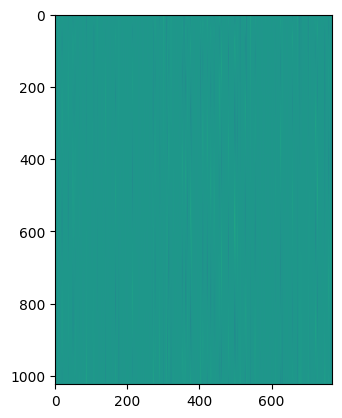

In [27]:
plt.imshow(GPT2.transformer.wpe.weight.detach().cpu().numpy())